# Udacity Self-Driving Car Engineer Nanodegree Program
## Project: Vehicle Detection and Tracking

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Load training data

In [1]:
import glob

car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')

print(len(car_images), 'vehicles loaded.')
print(len(noncar_images), 'non-vehicles loaded.')

8792 vehicles loaded.
8968 non-vehicles loaded.


### Visualize some of the training data

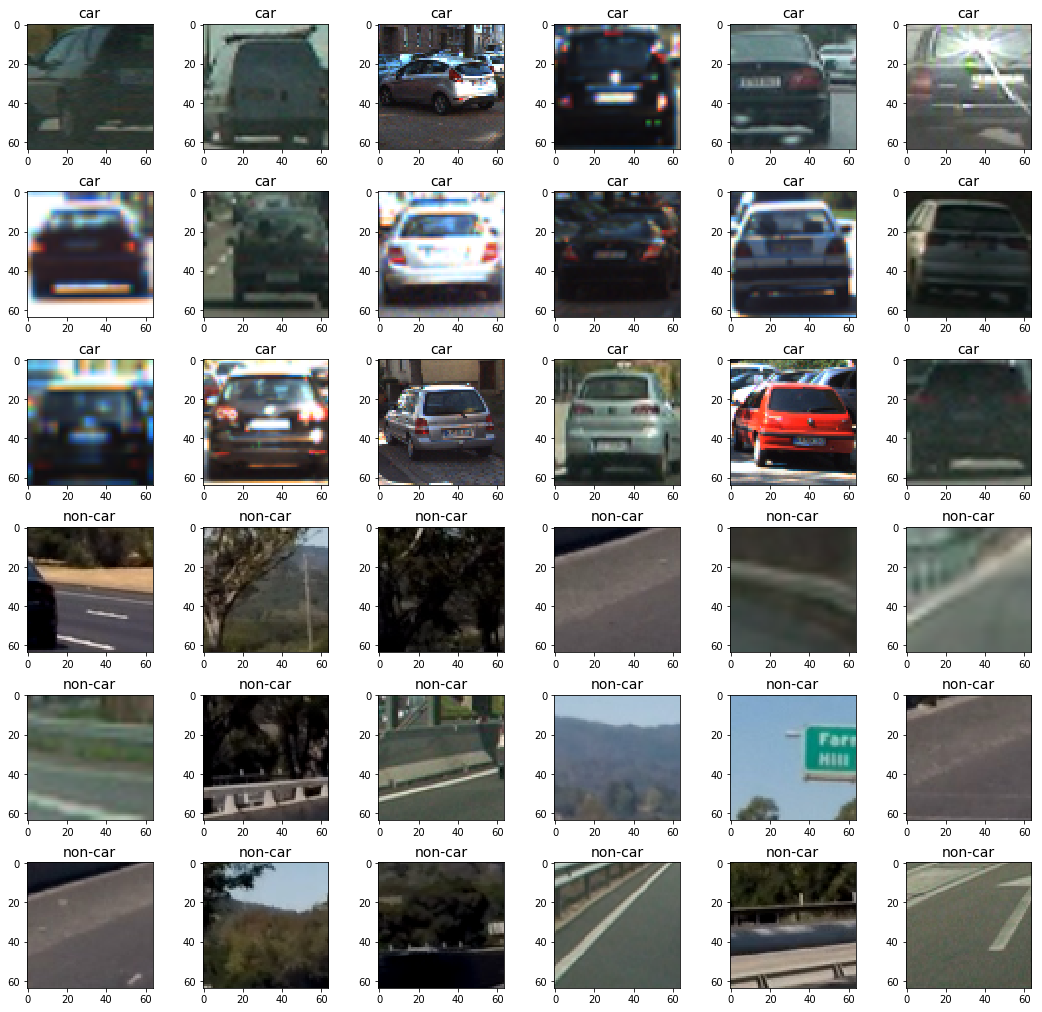

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

fig, axes = plt.subplots(6, 6, figsize=(18,18))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = axes.ravel()

i=0
# Pick some car images randomly and plot them
for filepath in np.random.choice(car_images, 18):
    img = mpimg.imread(filepath)
    axes[i].set_title('car', fontsize=14)
    axes[i].imshow(img)
    i += 1
# Pick some non-car images randomly and plot them
for filepath in np.random.choice(noncar_images, 18):
    img = mpimg.imread(filepath)
    axes[i].set_title('non-car', fontsize=14)
    axes[i].imshow(img)
    i += 1

This method was copied from lesson materials:

In [3]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis,
                                  feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis,
                       feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

Here is a helper method to plot two images side-by-side:

In [4]:
def plot_images_side_by_side(left_img, left_title, right_img, right_title):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    :param left_img: Image to be plotted on the left side.
    :param left_title: Title to be plotted on the left side.
    :param right_img: Image to be plotted on the right side.
    :param right_title: Title to be plotted on the right side.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    fig.tight_layout()
    axes[0].imshow(left_img, cmap='gray')
    axes[0].set_title(left_title, fontsize=14)
    axes[1].imshow(right_img, cmap='gray')
    axes[1].set_title(right_title, fontsize=14)
    return

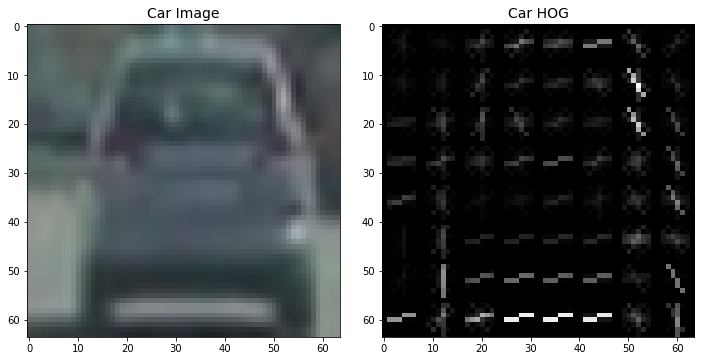

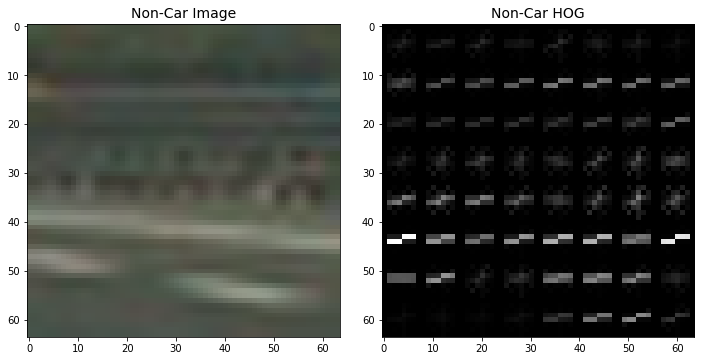

In [5]:


def test_car():
    img = mpimg.imread(car_images[1350])
    features, hog_image = get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    plot_images_side_by_side(img, 'Car Image', hog_image, 'Car HOG')

def test_non_car():
    img = mpimg.imread(noncar_images[1350])
    features, hog_image = get_hog_features(img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
    plot_images_side_by_side(img, 'Non-Car Image', hog_image, 'Non-Car HOG')

test_car()
test_non_car()
